## Probability Distributions and Sampling from them

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

### Probability Distribution Function Basics

When some stochastic process has distinct outcomes such as throwing two dice the *domain* of outcomes is just a list of all possibilities $\{2,3,4,5,6,7,8,9,10,11,12\}$. The probabilities describing what fraction of the time on average you expect these different values characterizes the system. These probabilities are $\{1/36, 2/36/3/36, 4/36, 5/36, 6/36, 5/36, 4/36, 3/36, 2/36, 1/36\}$. They are of course all positive values and the sum of all probabilities of possible outcomes equals one. I.e. something always happens.
The probability distribution function $p(x)$ is defined on the domain an records the probabilities such that $p(x) = Prob(X=x)$

How does this concept generalize to systems that have infinetly many outcomes? The probabilities have to be given as a function. Here it is defined for infintesimally small regions and we record it as a probability density such that the probability of the event to have $x$ be between $a$ and $b$ is given by $Prob(a\leq X\leq b) = \int_a^b p(x)dx$. 

The *cumulative probability distribution (CDF)* is simply its integral

$$
P(x)=Prob(X\leq x) = \int_{-\infty}^x p(x')dx'
$$

and 

$$
p(x) = \frac{d}{dx} P(x)
$$.

Also here we have 

$$\int_{x \in \mathbb{D}} p(x)dx = 1, 
$$

i.e. the PDF is normalized and it is also always positive. 

The mean of the distribution is given by 

$$
\langle x\rangle = \int_{-\infty}^\infty x p(x) dx
$$

And more generally the n-th moment of the distribution is given by

$$
\langle x^n\rangle = \int_{-\infty}^\infty x^n p(x) dx.
$$

These are in general distinct from the central moments:

$$
\langle (x-\langle x\rangle\rangle^n> = \int_{-\infty}^\infty (x-\langle x\rangle)^n p(x) dx.
$$


### Sampling Probability Distribution Functions
The velocity of atoms in a gas in thermodynamic equilibrium follow the Maxwell-Boltzmann distribution.
It is isotropic and we have for every dimension, $i$,

\begin{equation}
f(v_i) = \frac{1}{\sigma\,\sqrt{2\pi}} \, \exp\left(\frac{-v_i^2}{2\sigma^2}\right) \ \ \ \ \ \ \ \  (1)
\end{equation}
Where $\sigma^2 = k\,T/m$. 

The distribution of velocities considering them in 3 dimensions is just the product of three one dimensional velocity distribution functions

\begin{equation}
f_v \left(v_x, v_y, v_z\right) = f_v (v_x)f_v (v_y)f_v (v_z) 
 = \left(\frac{1}{\sigma\,\sqrt{2\pi}}\right)^3 \, \exp\left(-\frac{v_x^2+v_y^2+v_z^2}{2\sigma^2}\right) \ \ \ \ \ \ \ \  (1)
\end{equation}



The distribution for the speed is similar but has no negative values of course. For three dimensional velocities 

$$
f(v) = \sqrt{\frac{2}{\pi}}\sigma^{-3}\,v^2\,\exp\left(\frac{-v^2}{2\sigma^2}\right)
$$

We now would like to create a sample of particle speeds that follow the distribution given by equation (1).
How should we go about it? 

First we code up the analytical function (1) from above. 


integrates to one?: (1.0, 1.819971068991945e-12)


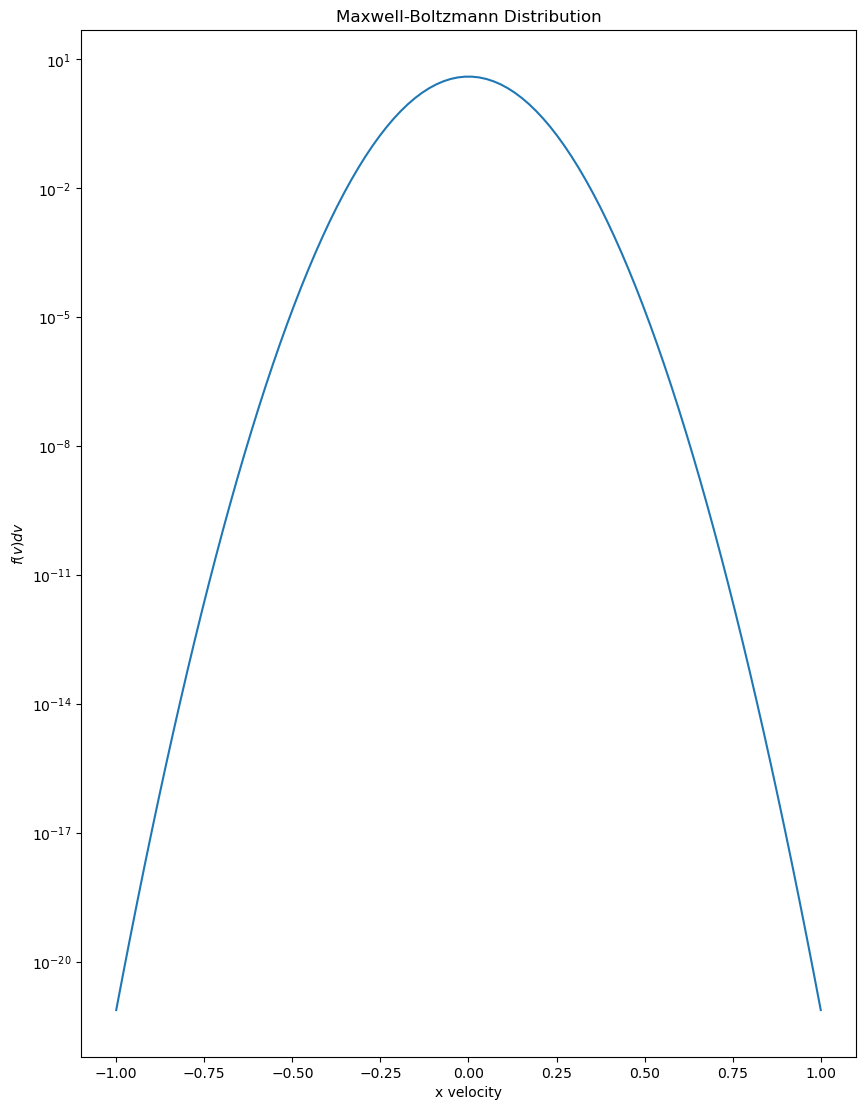

In [2]:
def MB_dist(v, sigma):
    f = np.sqrt(1./(2.*np.pi)) * sigma**(-1)  * np.exp(-v**2/2./sigma**2)
    return f

v = np.linspace(-1.,1.,100)
plt.semilogy(v,MB_dist(v,.1));
plt.xlabel('x velocity')
plt.ylabel(r'$f(v) dv$')
plt.title('Maxwell-Boltzmann Distribution');
from scipy.integrate import quad
f = lambda x: MB_dist(x, 0.1)
print('integrates to one?:', quad(f,-100.,100.))

That looks ok. We have a parabola in a linear-log plot and it integrates to one. 

Let's also practice some of the python commands that will be useful.

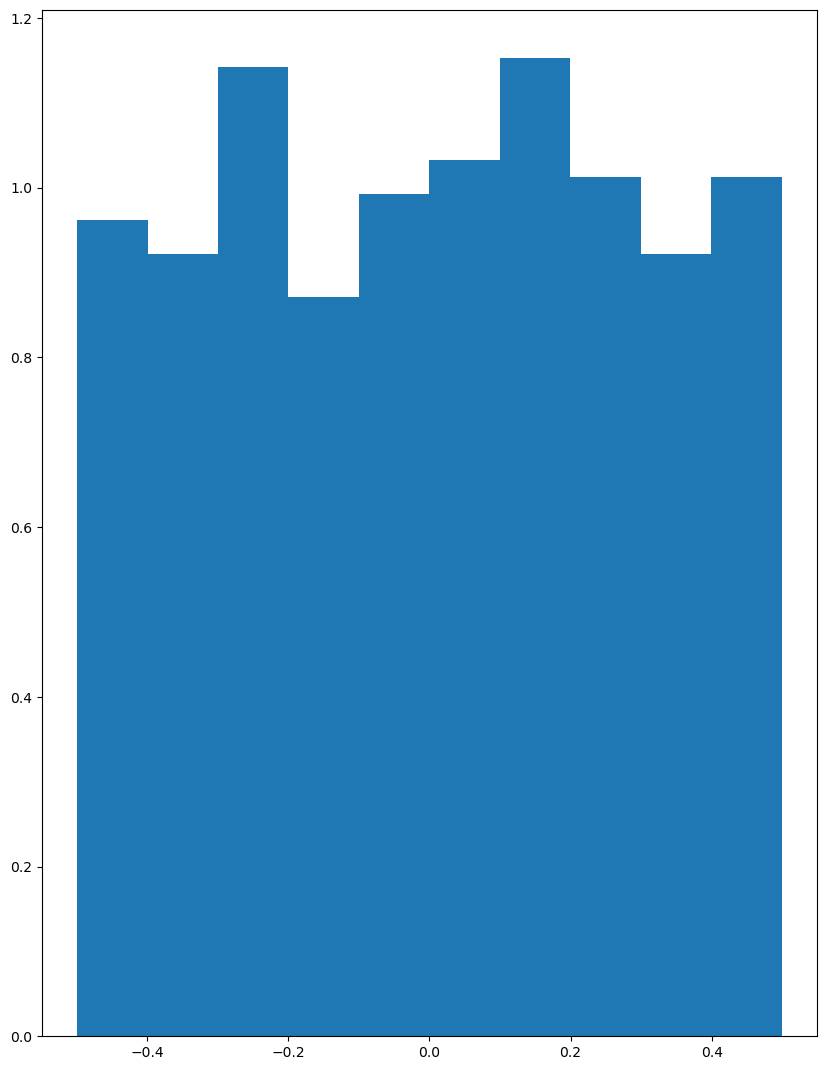

In [3]:
N = 1000
Nbins = 10
np.random.seed(3) # seeding the random number generator 
                  # makes sure we are all getting the same numbers everytime
v = np.random.random(N)-0.5
# we can use np.histogram
h, be = np.histogram(v,bins=np.linspace(-.5,.5,num=Nbins+1),density=True)
bc = (be[1:]+be[0:-1])/2 # bincenters
# or even easier use matplotlib's built in function hist
# notice the normed key word which normalizes so the integral is 1 over the histogram
hh = plt.hist(v,bins=Nbins,density=True) 
h = hh[0]
bc = ((hh[1])[1:]+(hh[1])[0:-1])/2

So now know how to draw random numbers and plot normalized histograms. 
But clearly we do not want a uniform distribution of variables. We want a Maxwell-Boltzmann. 

In [4]:
def MB_dist_realization(N, sigma):
    count = 0
    countnum = 0
    wide = 15.* 3.*sigma
    v = np.zeros(N) # array to hold the result

    while (count<N):
#        pick a random number for a trial v
        vt = np.random.random_sample()*wide-wide/2
        f = MB_dist(vt, sigma)
        ra = np.random.random_sample()*MB_dist(0,sigma) # between 0 and 1
        if (ra<f): # accept
            v[count] = vt
            count += 1
        countnum += 1
    print('calculated ', countnum, ' random numbers for a sample of ', N, \
        '. \n' ,1.*countnum/N , ' times more operations than in ideal case')
    
    return v
sigma = 0.5
v = MB_dist_realization(1000,sigma)

calculated  19350  random numbers for a sample of  1000 . 
 19.35  times more operations than in ideal case


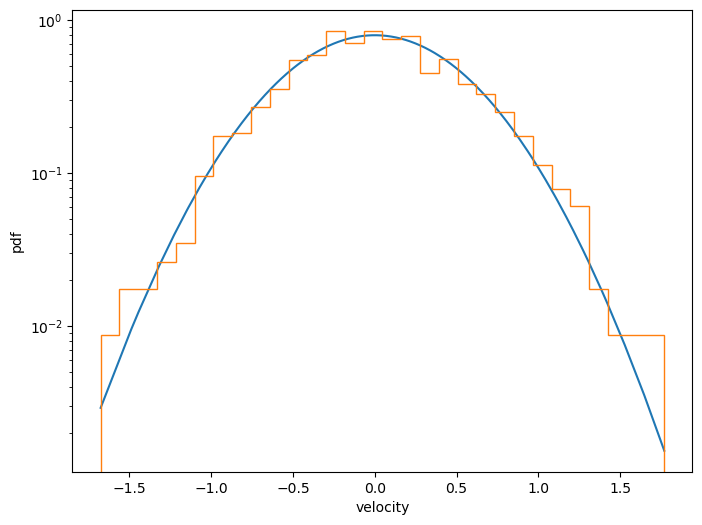

In [5]:
fig = plt.figure(figsize=((8,6)))
plt.semilogy(np.sort(v),MB_dist(np.sort(v),sigma),'-');
hh = plt.hist(v,bins=30,density=True,log=True,histtype='step') 
bw = (hh[1])[1]-(hh[1])[0]
plt.xlabel('velocity')
plt.ylabel('pdf');

In [6]:
(v.max(),v.std())

(1.7684973145324676, 0.5081372516591157)

### Box-Muller Method to generate Normal distribution

From uniformly distributed variables we can generate normal distributed ones using the so called <a href="http://en.wikipedia.org/wiki/Box–Muller_transform"><b>Box-Muller</b> transform.</a>

Starting from to random variables in the interval $[-1,1]$, $u$ and $v$ all we have to do is throw away all samples for which $s^2\equiv  u^2+v^2<=1$ just like in the calculating $\pi$ example we did when we discussed Monte-Carlo integration. With the remaining variables we simply get now two normal deviates $z_0 = u\sqrt{\frac{-2\ln s}{s}}$ and $z_1 = v\sqrt{\frac{-2\ln s}{s}}$. In our implementation we just combine the two. Note there is no autocorrelation between successive samples. 

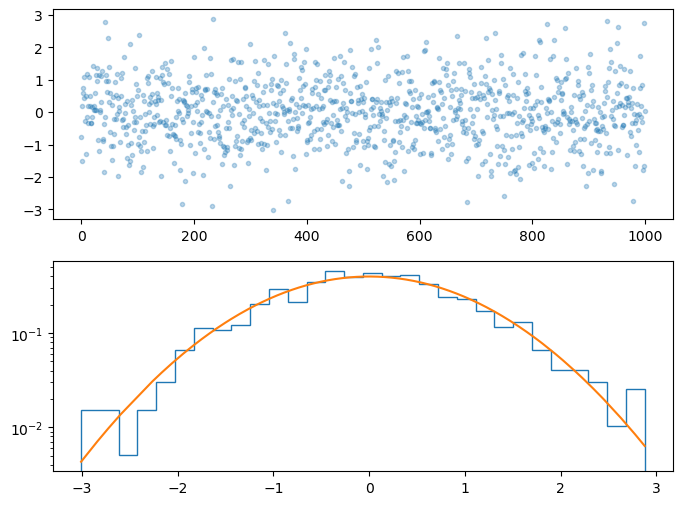

In [7]:
def sdnorm(z):
    """
    Standard normal pdf (Probability Density Function)
    """
    return np.exp(-z*z/2.)/np.sqrt(2*np.pi)

def BoxMueller(N,plotit=False):
    p = 2.*(np.random.random((2,N))-0.5)
    u = p[0,:]
    v = p[1,:]
    s = u**2+v**2
    r = np.sqrt(s)
    i = (np.where(r<=1. ))[0]
    z0 = u[i]*np.sqrt(-2.*np.log(s[i])/s[i])
    z1 = v[i]*np.sqrt(-2.*np.log(s[i])/s[i])
    return (np.append(z0,z1))[0:N]

N = 1000
s = BoxMueller(N)
fig = plt.figure(figsize=((8,6)))
plt.subplot(211)
plt.plot(s,'.',alpha=.3)
plt.subplot(212)
plt.hist(s, bins=30,density=1,log=1,histtype='step');
plt.plot(np.sort(s),sdnorm(np.sort(s)));


In [8]:
float(s.size)/N, np.pi/4

(1.0, 0.7853981633974483)

### Metropolis Hastings Algorithm

One of the most important algorithms ever developed is the so called [Metropolis-Hastings algorithm](http://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm). It allows one to generate samples for multidimensional distributions functions including for ones for which the normalization is not known. 

- Set Gaussian proposal distribution: $q(\theta_2 | \theta_1)$.
- Starting at $\theta_1$ draw a candidate point $\theta_{2c}$ from $q$.  
- Accept point with probability $\alpha(\theta_1,\theta_{2c})=\min(1,\frac{p(\theta_{2c} | x)}{p(\theta_1 | x )} ) = \min(1,\frac{p(x | \theta_{2c})}{p(x | \theta_1 )} ) $, otherwise reject and set $\theta_2 = \theta_1$.
- repeat

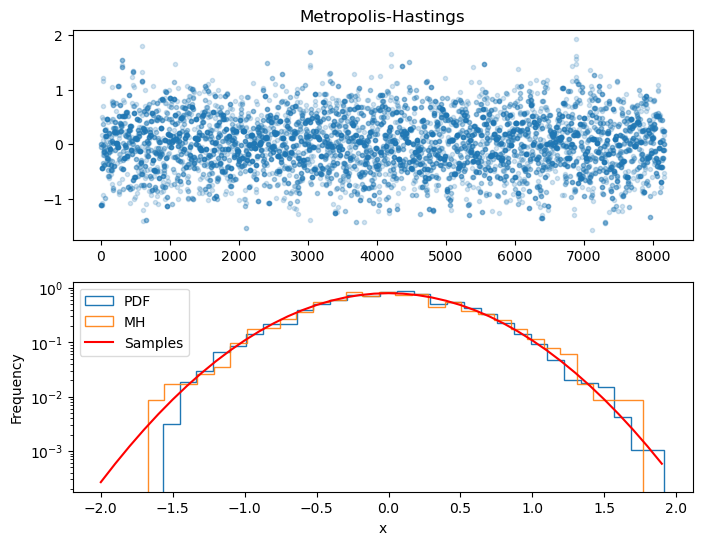

calculated  8270.0  random numbers for a sample of  8172 . 
 1.0121145374449338  times more operations than in ideal case


In [9]:
n = 3000
alpha = 2.1
x = .1
vec = []
vec.append(x)
count = 0
ct = 0
nburn = 100
while (count<n+nburn):
    can = x + np.random.uniform(-alpha,alpha) #candidate
    aprob = min([1.,MB_dist(can,sigma)/MB_dist(x,sigma)]) #acceptance probability
    u = np.random.uniform(0,1)
    if u < aprob:
        x = can
        vec.append(x)
        count += 1
    else:
        vec.append(x)
    ct += 1
vec = vec[nburn:]

#plotting the results:
#theoretical curve
x = np.arange(-2,2,.1)
y = MB_dist(x,sigma)

fig = plt.figure(figsize=((8,6)))
plt.subplot(211)
plt.title('Metropolis-Hastings')
plt.plot(vec,'.',alpha=.2)
plt.subplot(212)

plt.hist(vec, bins=30,density=True,log=1,histtype='step',label="PDF")
plt.hist(v,bins=30,density=True, log=1,alpha=0.9,histtype='step',label="MH")
plt.plot(x,y,'r-',label="Samples")
plt.ylabel('Frequency')
plt.xlabel('x')
leg = plt.legend()
leg.get_frame().set_alpha(0.7)
plt.show()
print('calculated ', 1.*(ct-1), ' random numbers for a sample of ', len(vec), \
       '. \n' ,1.*ct/len(vec) , ' times more operations than in ideal case' )


### Metropolis Hastings on a LogNormal Distribution

/var/folders/8h/csrqy1dd1x1d93qvzyh33kn40000gn/T/ipykernel_13357/3761484396.py:7: RuntimeWarning: invalid value encountered in log
  z = np.log(x)-mu
/var/folders/8h/csrqy1dd1x1d93qvzyh33kn40000gn/T/ipykernel_13357/3761484396.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  aprob = min([1.,sdlnorm(can,mu,sigma)/sdlnorm(x,mu,sigma)]) #acceptance probability
/var/folders/8h/csrqy1dd1x1d93qvzyh33kn40000gn/T/ipykernel_13357/3761484396.py:58: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  leg = plt.legend(('PDF', 'MH'),'best')


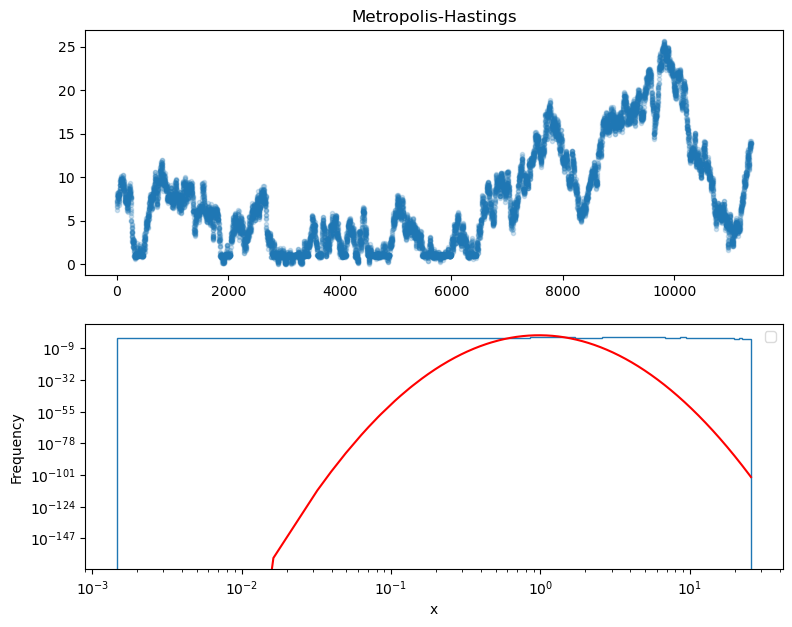

calculated  12374.0  random numbers for a sample of  11376 . 
 1.0878164556962024  times more operations than in ideal case


In [10]:
def sdlnorm(x,mu=1,sigma=.1):
    """
    Standard log normal pdf (Probability Density Function)
    """
    if (np.size(x) > 1):
        x[x==0.] = 1e-30 
    z = np.log(x)-mu
    return 1.*np.exp(-z*z/2./sigma**2)/np.sqrt(2*np.pi)/sigma/x

sigma = .15
mu = 0.
n = 10000
alpha = .5
x = 1.1
vec = []
vec.append(x)
count = 0
ct = 0
nburn = 1000
while (count<n+nburn):
    old_loglik = sdlnorm(x,mu,sigma)
    can = x + np.random.uniform(-alpha,alpha) #candidate
    new_loglik = sdlnorm(can,mu,sigma)
    aprob = min([1.,sdlnorm(can,mu,sigma)/sdlnorm(x,mu,sigma)]) #acceptance probability
    if (new_loglik > old_loglik):
        x = can
        vec.append(x)
        count += 1
    else:
        u = np.random.uniform(0,1)
        if (u < np.exp(new_loglik - old_loglik)):
            x = can
            vec.append(x)
            count += 1
        else:
            vec.append(x)

    x = vec[-1]
    ct += 1
vec = vec[nburn:]

#plotting the results:
#theoretical curve
x = np.sort(vec)
y = sdlnorm(x,mu,sigma)

fig = plt.figure(figsize=((9,7)))
ax = fig.add_subplot(211)
plt.title('Metropolis-Hastings')
plt.plot(vec,'.',alpha=.2)
ax = fig.add_subplot(212)

plt.hist((vec), bins=30,density=1,log=1,histtype='step')
plt.plot(x,y,'r-')
plt.xscale('log')
plt.ylabel('Frequency')
plt.xlabel('x')
leg = plt.legend(('PDF', 'MH'),'best')
leg.get_frame().set_alpha(0.7)
plt.show()
print('calculated ', 1.*(ct-1), ' random numbers for a sample of ', len(vec), \
       '. \n' ,1.*ct/len(vec) , ' times more operations than in ideal case' )


Now try this with a probability distributions function that is not normalized ... 

## Apply MH to model fitting

Create some data that looks like some observation from an experiment. Let's assume we have a linear relation $y=A + m\,x + U(\sigma)$ where $U(\sigma)$ is a normally distributed variable modeling a measurement error in $y$.

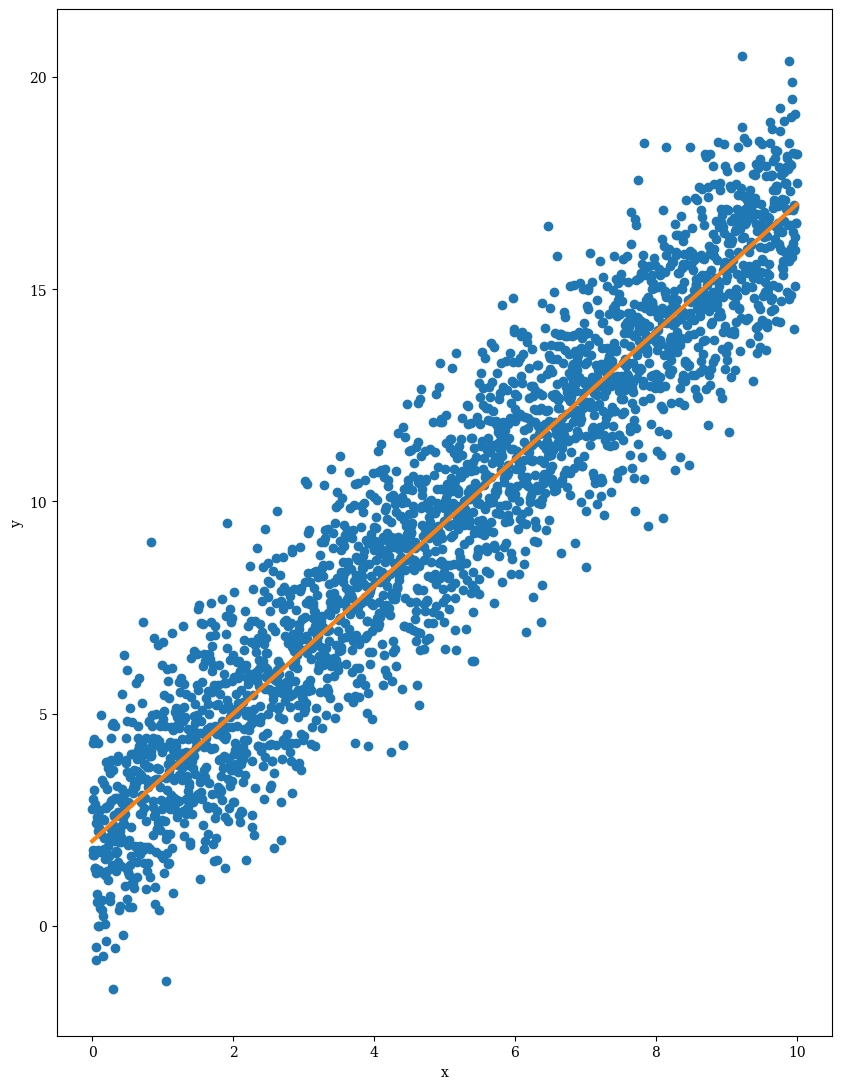

In [18]:
n = 2500

def linear_model(x, A, m):
    return A + m * x

np.random.seed(42)
x = np.linspace(0, 10, n)
A_true = 2
m_true = 1.5
sigma_true = 1.5
y = linear_model(x, A_true, m_true) + sigma_true * np.random.randn(n)

plt.plot(x,y,'o');
plt.plot(x,linear_model(x,A_true,m_true),'-',lw=3)
#plot(x,yq,'--');


plt.xlabel('x')
plt.ylabel('y');

We now want to see whether a model y = A + m x + normal distribution with width sigma fits our data. So we are attempting to fit 3 parameters, A, m, sigma

/var/folders/8h/csrqy1dd1x1d93qvzyh33kn40000gn/T/ipykernel_13357/2385035807.py:76: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  leg = plt.legend(('PDF', 'MH'),'best')


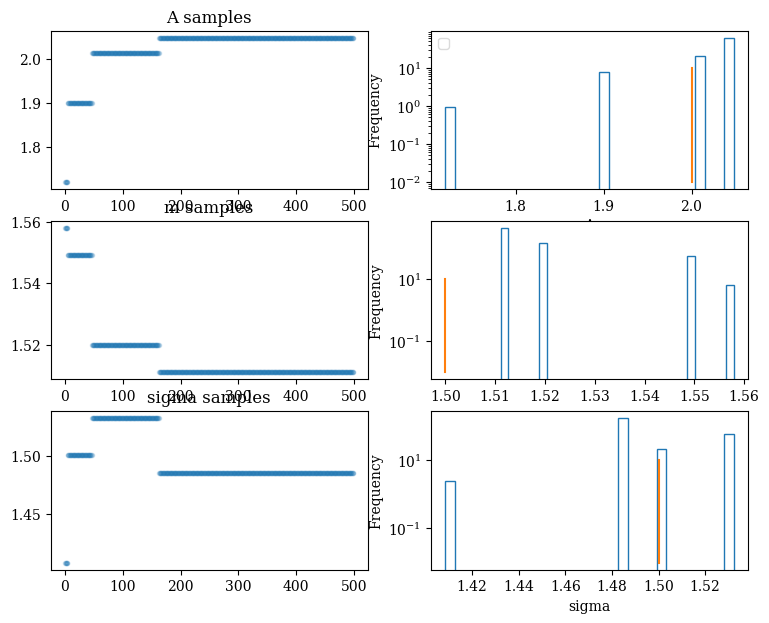

Acceptance rate: 0.006
A = 2.02 +/- 0.05
m = 1.52 +/- 0.01
sigma = 1.50 +/- 0.02


In [20]:

def log_likelihood(theta, x, y):
    A, m, sigma = theta
    y_model = linear_model(x, A, m)
    res = y - y_model
    return -0.5 * np.sum(res**2 / sigma**2 + np.log(2 * np.pi * sigma**2))


def metropolis_hastings(log_likelihood, proposal_width, n_steps, x, y):

    # Initialize parameter values and log-likelihood
    theta = np.array([0, 0, 1])
    log_prob = log_likelihood(theta, x, y)
    
    # Initialize arrays to store samples and acceptance rates
    samples = np.zeros((n_steps, 3))
    acceptances = np.zeros(n_steps)
    
    for i in range(n_steps):
        # Propose a new parameter vector by adding Gaussian noise
        theta_proposed = np.array([np.random.normal(theta[0], proposal_width[0]),
                                   np.random.normal(theta[1], proposal_width[1]),
                                   np.abs(np.random.normal(theta[2], proposal_width[2]))])
        
        # Calculate log-likelihood of proposed parameter vector
        log_prob_proposed = log_likelihood(theta_proposed, x, y)
        
        # Calculate acceptance probability
        log_alpha = log_prob_proposed - log_prob
        
        # Accept or reject proposal
        if np.log(np.random.rand()) < log_alpha:
            theta = theta_proposed
            log_prob = log_prob_proposed
            acceptances[i] = 1
        
        # Store current parameter values
        samples[i] = theta
    
    return samples, acceptances


# Set up the Metropolis-Hastings algorithm
proposal_width = [0.5, 0.5, 0.2]
n_steps = 1000

# Run the algorithm
samples, acceptances = metropolis_hastings(log_likelihood, proposal_width, n_steps, x, y)

# Discard first half of samples as burn-in
burn_in = n_steps // 2
samples = samples[burn_in:]
acceptance_rate = np.mean(acceptances[burn_in:])

# Calculate posterior means and standard deviations of parameters
A_mean, m_mean, sigma_mean = np.mean(samples, axis=0)
A_std, m_std, sigma_std = np.std(samples, axis=0)

#plotting the results:
#theoretical curve

Av = samples[:,0]
mv = samples[:,1]
sigmav = samples[:,2]

fig = plt.figure(figsize=((9,7)))
ax = fig.add_subplot(321)
plt.title('A samples')
plt.plot(Av,'.',alpha=.2)
ax = fig.add_subplot(322)
plt.hist((Av), bins=30,density=1,log=1,histtype='step')
plt.plot((A_true,A_true),(1e-2,1e1))

#pyplot.xscale('log')
plt.ylabel('Frequency')
plt.xlabel('A')
leg = plt.legend(('PDF', 'MH'),'best')
leg.get_frame().set_alpha(0.7)
ax = fig.add_subplot(323)
plt.title('m samples')
plt.plot(mv,'.',alpha=.2)

ax = fig.add_subplot(324)
plt.hist((mv), bins=30,density=1,log=1,histtype='step')
#pyplot.xscale('log')
plt.ylabel('Frequency')
plt.xlabel('m')
plt.plot((m_true,m_true),(1e-2,1e1))
ax = fig.add_subplot(325)
plt.title('sigma samples')
plt.plot(sigmav,'.',alpha=.2)
ax = fig.add_subplot(326)
plt.hist((sigmav), bins=30,density=1,log=1,histtype='step')
plt.plot((sigma_true,sigma_true),(1e-2,1e1))
#pyplot.xscale('log')
plt.ylabel('Frequency')
plt.xlabel('sigma')


plt.show()


# Print results
print(f"Acceptance rate: {acceptance_rate:.3f}")
print(f"A = {A_mean:.2f} +/- {A_std:.2f}")
print(f"m = {m_mean:.2f} +/- {m_std:.2f}")
print(f"sigma = {sigma_mean:.2f} +/- {sigma_std:.2f}")


In [22]:
samples.shape

(500, 3)

In [13]:
print("A=", np.mean(Av),"+-", np.std(Av))
print("m=", np.mean(mv),"+-", np.std(mv))
print("sigma=",np.mean(sigmav),"+-", np.std(sigmav))

A= 2.002606340196055 +- 0.013282802993244502
m= 1.5142556760031542 +- 0.00541921757391659
sigma= 1.506305191990411 +- 0.00022574942739354162


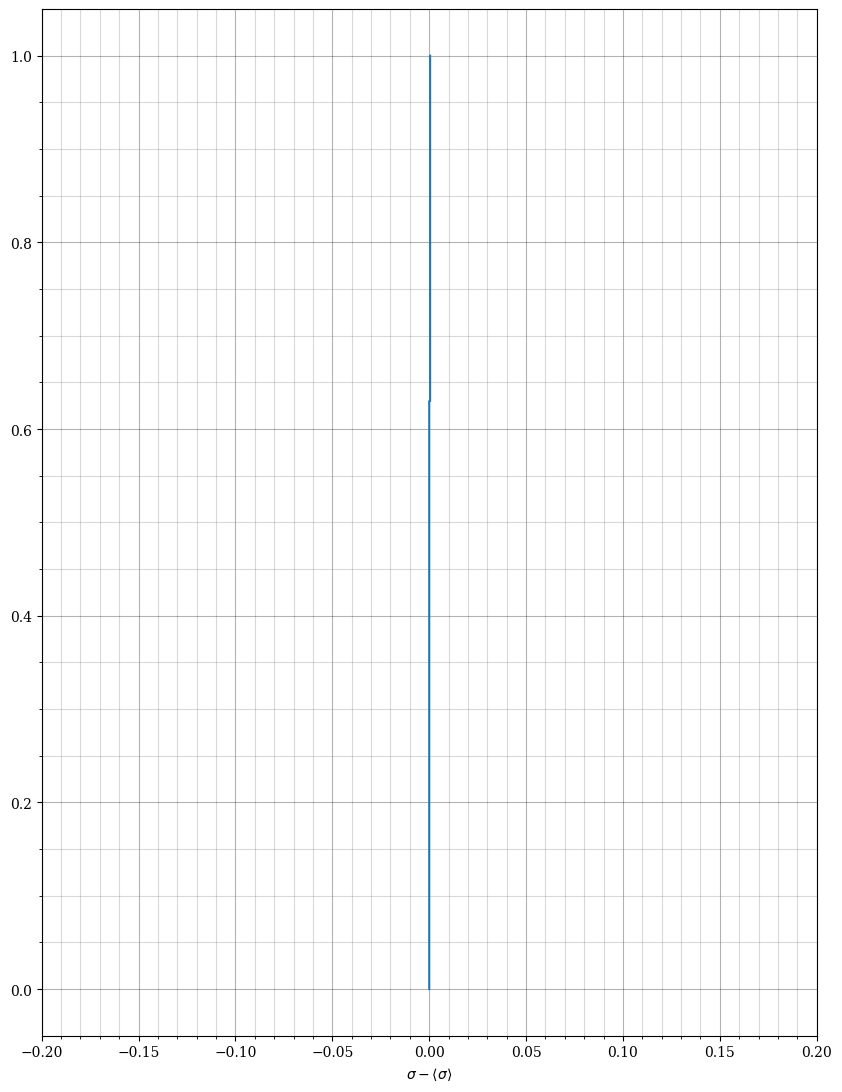

In [14]:
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(np.sort(sigmav)-np.median(sigmav),np.linspace(0,1.,len(sigmav)))
plt.minorticks_on()
plt.xlim((-.2,.2))
plt.xlabel(r'$\sigma - \langle \sigma \rangle$')
plt.grid( which='minor', color='grey', linestyle='-',alpha=0.3)
plt.grid( which='major', color='black', linestyle='-',alpha=0.3)

In [15]:
print("Values with 5 and 95% of the distribution")
print("A    =", np.median(Av),"+", np.percentile(Av, 95.)-np.percentile(Av,50), "-", np.percentile(Av,50)-np.percentile(Av, 5.))
print("m    =", np.median(mv),"+", np.percentile(mv, 95.)-np.percentile(mv,50), "-", np.percentile(mv,50)-np.percentile(mv, 5.))
print("sigma=", np.median(sigmav),"+", np.percentile(sigmav, 95.)-np.percentile(sigmav,50), "-", np.percentile(sigmav,50)-np.percentile(sigmav, 5.))

Values with 5 and 95% of the distribution
A    = 1.9924269838311606 + 0.02751177395917459 - 0.0
m    = 1.5184087261486585 + 0.0 - 0.011224459852713808
sigma= 1.5061321875521325 + 0.0004675795629147661 - 0.0


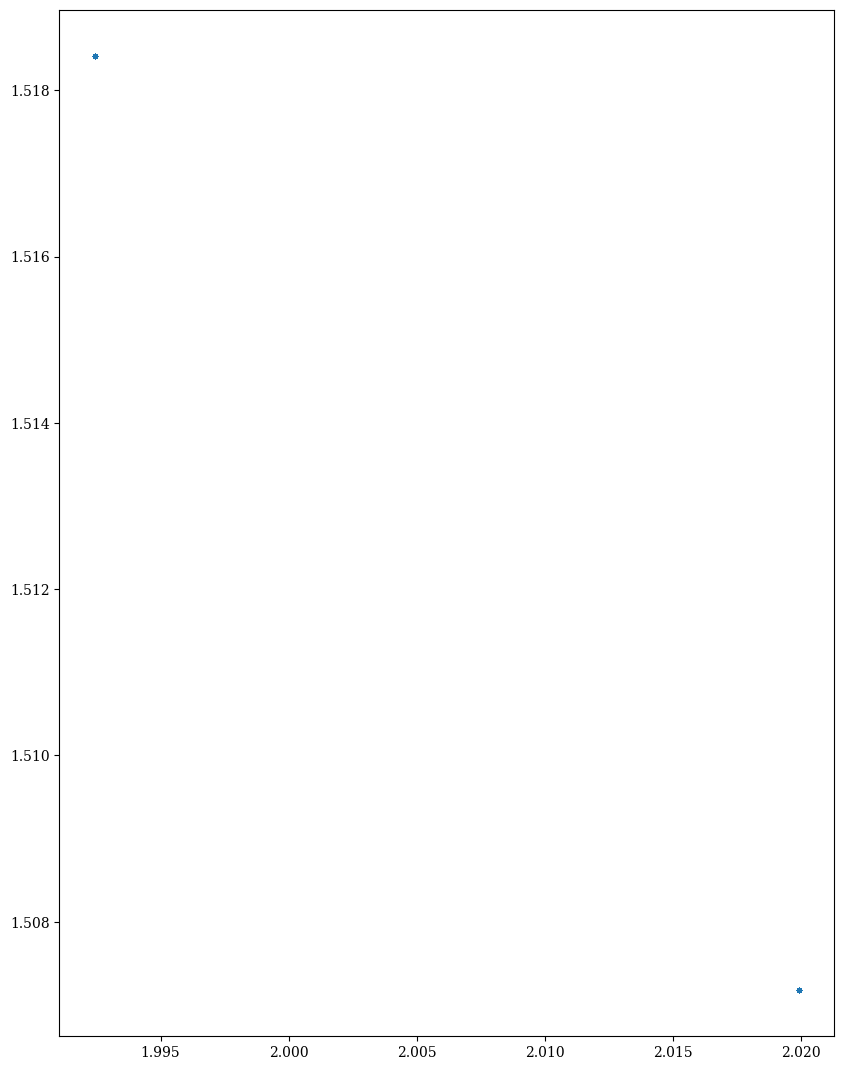

In [16]:
plt.plot(Av,mv,'.',alpha=.01);

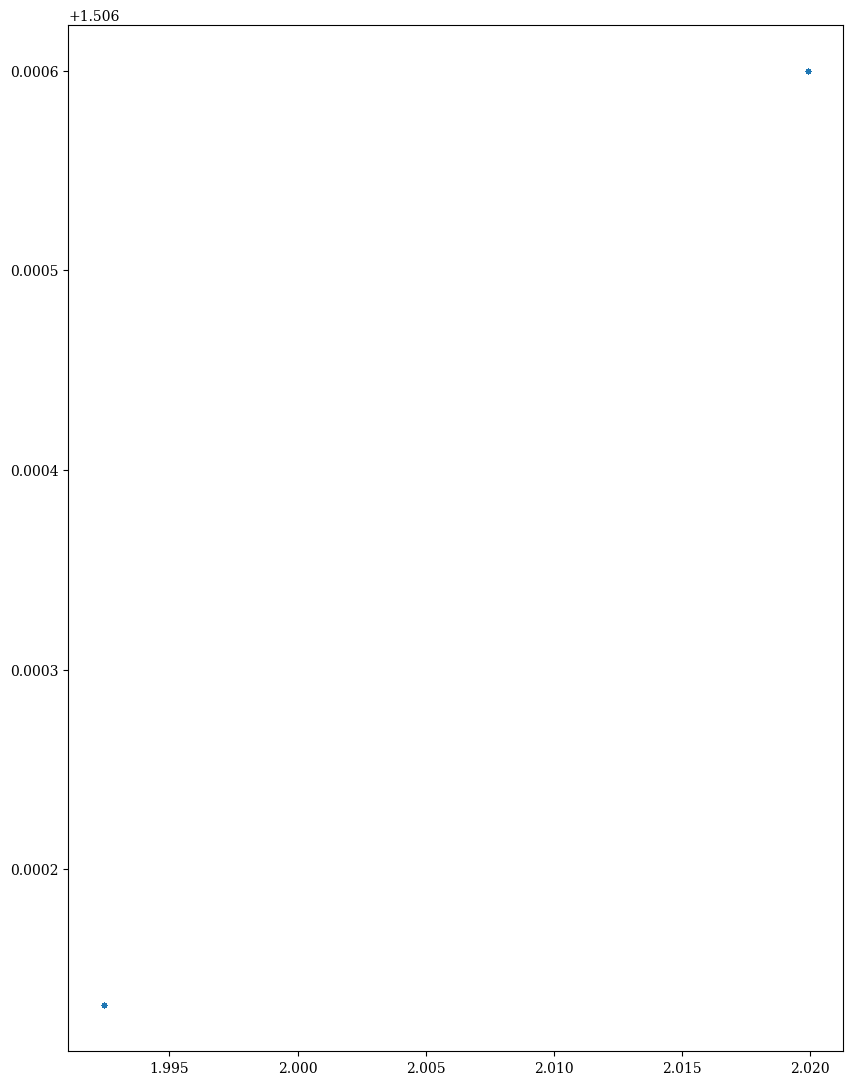

In [17]:
plt.plot(Av,sigmav,'.',alpha=.01);